In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import iris

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from IPython.display import Markdown as md
from plot_4p4 import extract_vortex_info, plot_t_bright_himawari
from func_4p4 import open_file

import matplotlib
%matplotlib inline
from matplotlib.patches import Rectangle
import cmocean

In [2]:
# plot characteristics 
lon_start = 93.0 # 88.0
lon_end = 130.0 # 130.0
lat_start = -4.0 # -6.0
lat_end = 20.0 # 23.0

bounds = [lon_start, lon_end, lat_start, lat_end]

In [3]:
# read in 4p4 MetUM data 
data_path_4p4 = '/nobackup/earshar/borneo/20181021T1200Z_SEA4_km4p4_ra1tld_pverb.pp'
# data_path_4p4 = '{0}_pverb.pp'.format(data_path_4p4)
pcubes = iris.load(data_path_4p4)
prcp_4p4_data = xr.DataArray.from_iris(pcubes.extract('stratiform_rainfall_flux')[1])

In [4]:
# subset and extract 12-h accumulated precipitation
prcp_4p4_data = prcp_4p4_data.sel(longitude=slice(bounds[0], bounds[1]), latitude=slice(bounds[2], bounds[3]))
prcp_4p4_data = prcp_4p4_data * 3600. 

In [5]:
# calculate 12-h accumulated precipitation from 1-h precipitation amounts 
prcp_4p4_data = prcp_4p4_data.resample(time="12H").sum().sel(time = slice('2018-10-21T12', '2018-10-26T12') )

In [6]:
# read in GPM data 
gpm_path = '/nobackup/earshar/borneo/GPMHH_201810.nc'
gpm_data = xr.open_dataset(gpm_path).sel(lon=slice(bounds[0], bounds[1]), lat=slice(bounds[2], bounds[3]))
prcp_gpm = gpm_data.precipitationCal

In [7]:
# divide by 2 (each 30-min interval contains precip rate in mm/hr)
prcp_gpm = prcp_gpm / 2

In [8]:
# resample GPM data to calculate 12-h accumulated precipitation
prcp_gpm_12h = prcp_gpm.sel(time=slice('2018-10-21T12', '2018-10-26T12')).resample(time="12H").sum()

In [9]:
# set up dummy array to hold N768 MetUM data  
Tp = [24, 36, 48, 60, 72, 84, 96, 108, 120]
prcp_n768_dims = [len(Tp), prcp_4p4_data.latitude.shape[0], prcp_4p4_data.longitude.shape[0]]

prcp_n768_data = xr.DataArray(np.ones(prcp_n768_dims),
                        dims=["time", "latitude", "longitude"],
                        coords={
                            "time": prcp_gpm_12h.time[1:-1],
                            "latitude": prcp_4p4_data.latitude,
                            "longitude": prcp_4p4_data.longitude,
                        },
                        )

In [10]:
# fill dummy array with data by looping over input files 
for i, t in enumerate(Tp):
    metum_n768_path = '/nobackup/earshar/borneo/case_20181021T1200Z_N768_v2/umglaa_pa{0:03d}.nc'.format(t - 12)
    data_n768 = xr.open_dataset(metum_n768_path)
    data_n768 = data_n768["tot_precip"].squeeze('t_1').squeeze('surface').sel(longitude=slice(bounds[0], bounds[1]),
                                                                              latitude=slice(bounds[2], bounds[3]))

    # interpolate N768 MetUM data onto 4p4 MetUM grid
    prcp_n768_data[i, :, :] = data_n768.interp(longitude=prcp_4p4_data["longitude"],
                                               latitude=prcp_4p4_data["latitude"],
                                               method="linear")

In [11]:
# also interpolate GPM data onto 4p4 MetUM grid
prcp_gpm_12h = prcp_gpm_12h.interp(lon=prcp_4p4_data["longitude"],
                                    lat=prcp_4p4_data["latitude"],
                                    method="linear")

In [12]:
# align all three arrays so that time dimension is identical
prcp_gpm_12h = prcp_gpm_12h.sel(time=slice('2018-10-22T00', '2018-10-26T00'))
prcp_4p4_data = prcp_4p4_data.sel(time=slice('2018-10-22T00', '2018-10-26T00'))
prcp_n768_data = prcp_n768_data # no change 

In [13]:
# transpose GPM data 
prcp_gpm_data = prcp_gpm_12h.transpose('time','latitude','longitude')

In [14]:
# vortex track + intensity data 
vortex_path = '/nobackup/earshar/borneo/bv_2018102112_track.csv'
bv_lat, bv_lon, bv_time = extract_vortex_info(vortex_path)

In [15]:
# calculate accumulated, area-averaged precipitation along the vortex track 
acc_prcp_gpm = xr.DataArray(np.ones(prcp_gpm_data.time.shape[0]),
                            dims=["time"],
                            coords={
                            "time": prcp_gpm_data.time
                            },
                        )

In [16]:
# repeat for the other datasets
acc_prcp_4p4 = xr.DataArray(np.ones(prcp_4p4_data.time.shape[0]),
                            dims=["time"],
                            coords={
                            "time": prcp_4p4_data.time
                            },
                        )

acc_prcp_n768 = xr.DataArray(np.ones(prcp_n768_data.time.shape[0]),
                            dims=["time"],
                            coords={
                            "time": prcp_n768_data.time
                            },
                        )

In [17]:
# set indices in vortex array for 12-h intervals 
xi = [2,4,6,8,10,12,14,16,18]

In [41]:
# set radius for area-averaged precipitation calculation 
r0 = 2.0

In [42]:
for i, it in enumerate(np.arange(0,9)):
    xii = xi[i]

    # calculate area-averaged, accumulated precipitation 
    pr_gpm = prcp_gpm_data[it,:,:]
    pr_4p4 = prcp_4p4_data[it,:,:]
    pr_n768 = prcp_n768_data[it,:,:]

    pr_gpm = pr_gpm.loc[bv_lat[xii]-r0:bv_lat[xii]+r0,
                        bv_lon[xii]-r0:bv_lon[xii]+r0].mean()
    pr_4p4 = pr_4p4.loc[bv_lat[xii]-r0:bv_lat[xii]+r0,
                        bv_lon[xii]-r0:bv_lon[xii]+r0].mean()
    pr_n768 = pr_n768.loc[bv_lat[xii]-r0:bv_lat[xii]+r0,
                          bv_lon[xii]-r0:bv_lon[xii]+r0].mean()

    acc_prcp_gpm[i] = pr_gpm.data
    acc_prcp_4p4[i] = pr_4p4.data
    acc_prcp_n768[i] = pr_n768.data

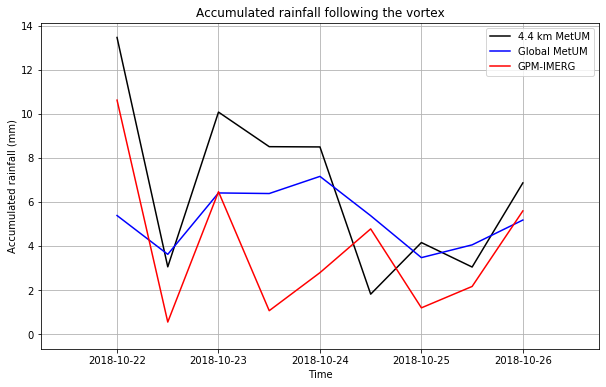

In [43]:
# produce time-series plot 
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(bv_time, np.zeros(21), color='k', alpha=0.0)
ax.plot(bv_time[2:19:2], acc_prcp_4p4, color='k', label='4.4 km MetUM')
ax.plot(bv_time[2:19:2], acc_prcp_n768, color='b', label='Global MetUM')
ax.plot(bv_time[2:19:2], acc_prcp_gpm, color='r', label='GPM-IMERG')
ax.set(xlabel='Time', ylabel='Accumulated rainfall (mm)',
        title='Accumulated rainfall following the vortex')
ax.grid(True)
ax.legend(loc='upper right')

In [44]:
fig.savefig(f'fig5b_new_{r0}deg.png')